In [1]:
library(readr)
library(readxl)
library(dplyr)

library(tidyverse)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.4     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [2]:
options(repr.plot.width = 20, repr.plot.height = 10)

In [3]:
library(fgsea)
get_gsea <- function(df) {
  df <- df %>% drop_na()
  # Ensure gene names are rownames and vector is a matrix
  gene_vec <- df$fold_change
  names(gene_vec) <- df$gene

  # Wrap into a matrix for GSVA (genes x samples)
  # Read GMT
  gmt <- gmtPathways("mapk.gmt")

  # Run ssGSEA
  ss <- fgsea(stats = gene_vec, pathways = gmt)

  # Return as data frame
  ss_df <- as.data.frame((ss))
  return(ss_df)
}


In [5]:
predicted1 <- read_csv("/large_storage/ctc/userspace/alishba.imran/state-sets/braf_hvg_final1/eval_last.ckpt/C32_pred_de.csv")
predicted2 <- read_csv("/large_storage/ctc/userspace/alishba.imran/state-sets/braf_hvg_final1/eval_last.ckpt/SK-MEL-2_pred_de.csv")
predicted3 <- read_csv("/large_storage/ctc/userspace/alishba.imran/state-sets/braf_hvg_final1/eval_last.ckpt/SK-MEL-2_pred_de.csv")
predicted1$cell_line <- 'C32'
predicted2$cell_line <- 'SK-MEL-2'
predicted <- bind_rows(predicted1, predicted2)
ground_truth1 <- read_csv("/large_storage/ctc/userspace/alishba.imran/state-sets/braf_hvg_final1/eval_last.ckpt/C32_real_de.csv")
ground_truth2 <- read_csv("/large_storage/ctc/userspace/alishba.imran/state-sets/braf_hvg_final1/eval_last.ckpt/SK-MEL-2_real_de.csv")
ground_truth1$cell_line <- 'C32'
ground_truth2$cell_line <- 'SK-MEL-2'
ground_truth <- bind_rows(ground_truth1, ground_truth2)


Rows: 6000 Columns: 10
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): target, reference
dbl (8): feature, target_mean, reference_mean, percent_change, fold_change, ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Rows: 6000 Columns: 10
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): target, reference
dbl (8): feature, target_mean, reference_mean, percent_change, fold_change, ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 6000 Columns: 10
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): target, reference
dbl (8): feature, target_mean, reference_mean, percent_change, fold_change, ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 6000 Columns: 10
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): target, reference
dbl (8): feature, target_mean, reference_mean, percent_change, fold_change, ...

ℹ Use `spec

In [6]:
table(predicted$target)


[('Vemurafenib', 0.05, 'uM')]  [('Vemurafenib', 0.5, 'uM')] 
                         4000                          4000 
 [('Vemurafenib', 5.0, 'uM')] 
                         4000 

In [7]:
library(reticulate)
library(dplyr)

# Load numpy and the .npy file
np <- import("numpy")
gene_names <- np$load("/large_storage/ctc/userspace/aadduri/datasets/tahoe_19k_to_2k_names.npy", allow_pickle = TRUE)
# Convert to R character vector
gene_names <- as.character(gene_names)
# Create a data frame mapping index to gene name
gene_map <- tibble(
  feature = seq_along(gene_names) - 1,  # Python 0-based index
  gene = gene_names
)
# Join with your predicted data frame
predicted <- predicted %>%
  left_join(gene_map, by = "feature")
ground_truth<- ground_truth %>%
  left_join(gene_map, by = "feature")
fold1_pred<- fold1_pred %>%
  left_join(gene_map, by = "feature")
fold2_pred<- fold2_pred %>%
  left_join(gene_map, by = "feature")

In [8]:

fold2_pred_gsea <- fold2_pred %>%
  group_by(cell_line, target) %>% 
  group_split() %>%
  map_dfr(function(df_group) {
    gsea_res <- get_gsea(df_group)
    gsea_res$cell_line <- unique(df_group$cell_line)
    gsea_res$target <- unique(df_group$target)
    gsea_res
  })

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (24.95% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”


Warning message in fgseaMultilevel(pathways = pathways, stats = stats, minSize = minSize, :
“There were 9 pathways for which P-values were not calculated properly due to unbalanced (positive and negative) gene-level statistic values. For such pathways pval, padj, NES, log2err are set to NA. You can try to increase the value of the argument nPermSimple (for example set it nPermSimple = 10000)”
Warning message in fgseaMultilevel(pathways = pathways, stats = stats, minSize = minSize, :
“For some of the pathways the P-values were likely overestimated. For such pathways log2err is set to NA.”
Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (32.94% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
Warning message in fgseaMultilevel(pathways = pathways, stats = stats, minSize = minSize, :
“There were 9 pathways for which P-values were not calculated properly du

In [9]:

fold1_pred_gsea <- fold1_pred %>%
  group_by(cell_line, target) %>% 
  group_split() %>%
  map_dfr(function(df_group) {
    gsea_res <- get_gsea(df_group)
    gsea_res$cell_line <- unique(df_group$cell_line)
    gsea_res$target <- unique(df_group$target)
    gsea_res
  })

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (23.39% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
Warning message in fgseaMultilevel(pathways = pathways, stats = stats, minSize = minSize, :
“There were 3 pathways for which P-values were not calculated properly due to unbalanced (positive and negative) gene-level statistic values. For such pathways pval, padj, NES, log2err are set to NA. You can try to increase the value of the argument nPermSimple (for example set it nPermSimple = 10000)”
Warning message in fgseaMultilevel(pathways = pathways, stats = stats, minSize = minSize, :
“For some of the pathways the P-values were likely overestimated. For such pathways log2err is set to NA.”
Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (32.31% of the list).
The order of 

In [10]:
grounds_gsea <- ground_truth %>%
  group_by(cell_line, target) %>%
  group_split() %>%
  map_dfr(function(df_group) {
    gsea_res <- get_gsea(df_group)
    gsea_res$cell_line <- unique(df_group$cell_line)
    gsea_res$target <- unique(df_group$target)
    gsea_res
  })

predicted_gsea <- predicted %>%
  group_by(cell_line, target) %>%
  group_split() %>%
  map_dfr(function(df_group) {
    gsea_res <- get_gsea(df_group)
    gsea_res$cell_line <- unique(df_group$cell_line)
    gsea_res$target <- unique(df_group$target)
    gsea_res
  })

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (17.77% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“All values in the stats vector are greater than zero and scoreType is "std", maybe you should switch to scoreType = "pos".”
Warning message in fgseaMultilevel(pathways = pathways, stats = stats, minSize = minSize, :
“There were 1 pathways for which P-values were not calculated properly due to unbalanced (positive and negative) gene-level statistic values. For such pathways pval, padj, NES, log2err are set to NA. You can try to increase the value of the argument nPermSimple (for example set it nPermSimple = 10000)”
Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (17.28% of the lis

In [17]:
# Step 1: merge predicted and truth
merged1 <- merge(predicted_gsea, grounds_gsea, by = c('cell_line', 'target', 'pathway'), suffixes = c("_predicted", "_truth"))


In [18]:
merged1$cell_line <- ifelse(
  merged1$cell_line == 'C32',
  'C32 - BRAF v600E mutant Melanoma',
  'SK-MEL-2 - W.T. BRAF melanoma'
)

In [19]:
merged1 <- merged1 %>% pivot_longer(c('NES_predicted', 'NES_truth')) %>% as.data.frame()

In [20]:
merged1$name <- ifelse(merged1$name == 'NES_truth', 'True Normalized Enrichment', 'predicted Normalized Enrichment')

In [21]:
set <- c('GOBP_REGULATION_OF_CYCLASE_ACTIVITY' )

In [22]:
library(ggpubr)

In [23]:
library(dplyr)
library(stringr)

merged1 <- merged1 %>%
  mutate(dose = str_split_fixed(target, ",", 2)[, 2]) %>%
  mutate(dose = as.numeric(dose))


Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `dose = as.numeric(dose)`.
Caused by warning:
! NAs introduced by coercion”


In [24]:


summary_df <- merged1 %>%
  filter(pathway %in% set) %>%
  group_by(cell_line, dose, pathway, name) %>%
  summarise(
    mean_value = mean(value, na.rm = TRUE),
    se = sd(value, na.rm = TRUE) / sqrt(n()),
    .groups = "drop"
  )

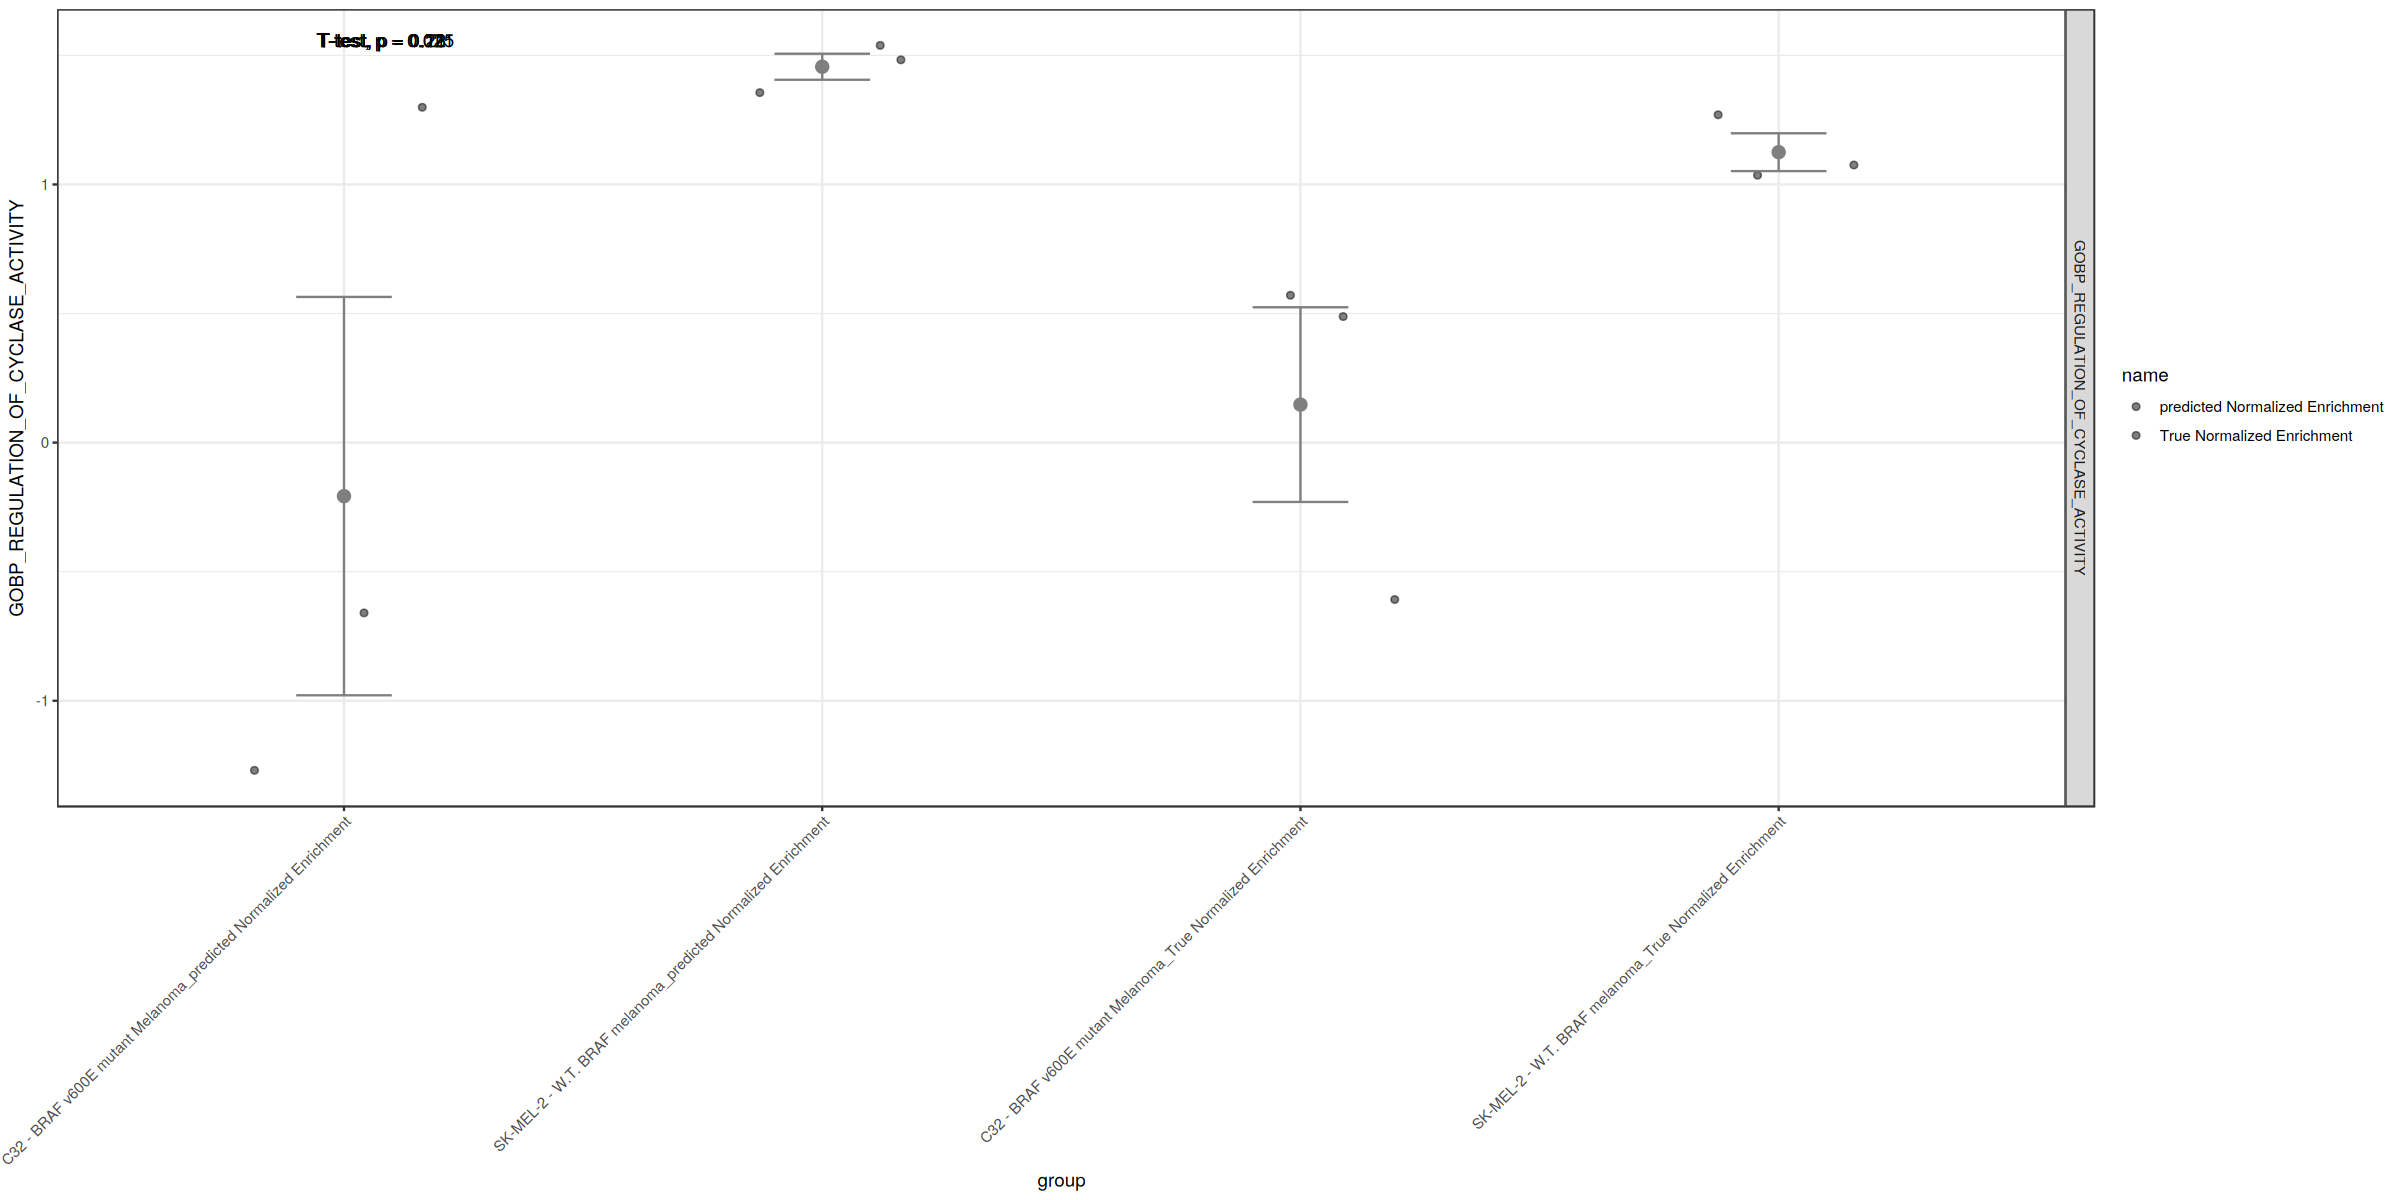

In [25]:
# Assuming 'name' contains your true/predicted labels
merged1 <- merged1 %>%
  mutate(group = interaction(cell_line, name, sep = "_"))

summary_df <- summary_df %>%
  mutate(group = interaction(cell_line, name, sep = "_"))

p <- ggplot(
  merged1 %>% filter(pathway %in% set),
  aes(x = group, y = value, fill =name)
) +
  geom_point(position = position_jitter(width = 0.2), alpha = 0.5) +
  geom_errorbar(
    data = summary_df,
    aes(
      x = group,
      y = mean_value,
      ymin = mean_value - se,
      ymax = mean_value + se,
      color = dose
    ),
    inherit.aes = FALSE,
    width = 0.2
  ) +
  geom_point(
    data = summary_df,
    aes(x = group, y = mean_value, color = dose),
    inherit.aes = FALSE,
    size = 3
  ) +
  stat_compare_means(method = "t.test") +
  theme_bw() +
  facet_grid(rows = vars(pathway)) +
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
  ylab("GOBP_REGULATION_OF_CYCLASE_ACTIVITY")

print(p)

In [26]:
options(repr.plot.width = 10, repr.plot.height = 10)

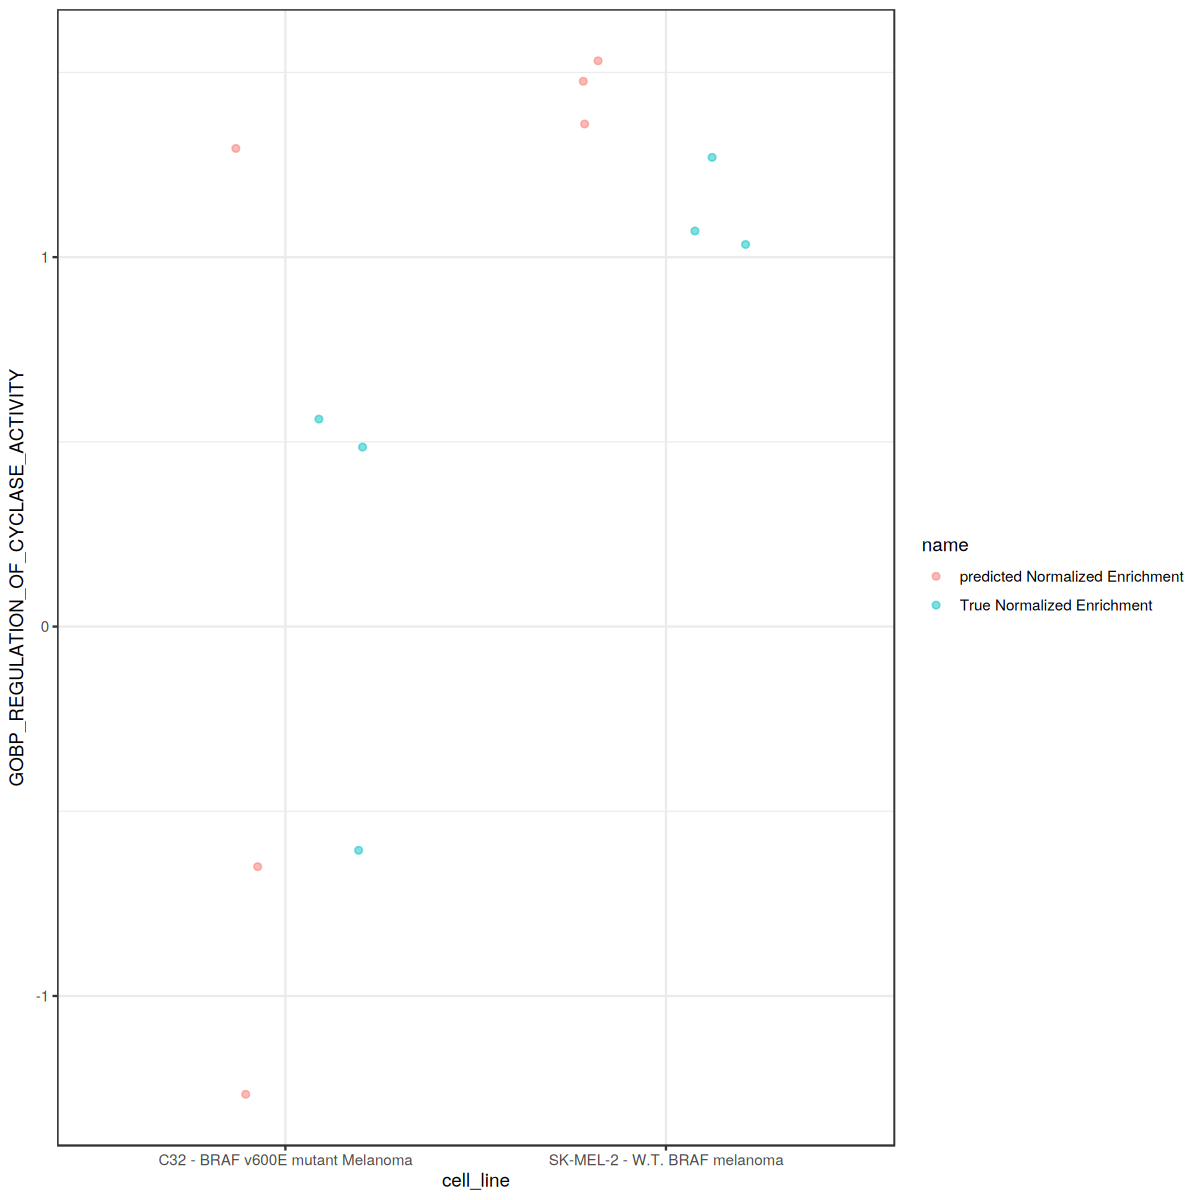

In [27]:
library(ggplot2)
library(ggpubr)

# Define comparisons for both scenarios
cell_line_comparisons <- list(c('C32 - BRAF v600E mutant Melanoma',
                               'SK-MEL-2 - W.T. BRAF melanoma'))

dodge_width <- 0.5

p <- ggplot(
  merged1 %>% filter(pathway %in% set),
  aes(x = cell_line, y = value, color = name, fill = name)
) +
  geom_point(
    position = position_jitterdodge(jitter.width = 0.2, dodge.width = dodge_width),
    alpha = 0.5
  ) +
  # T-test comparing cell lines within each 'name' group
  # T-test comparing 'name' groups within each cell line
  theme_bw() +
  ylab("GOBP_REGULATION_OF_CYCLASE_ACTIVITY")

print(p)

In [28]:
ggsave('BRAF_predictions.pdf', p)

Saving 7 x 7 in image


In [29]:
options(repr.plot.width = 20, repr.plot.height = 5)

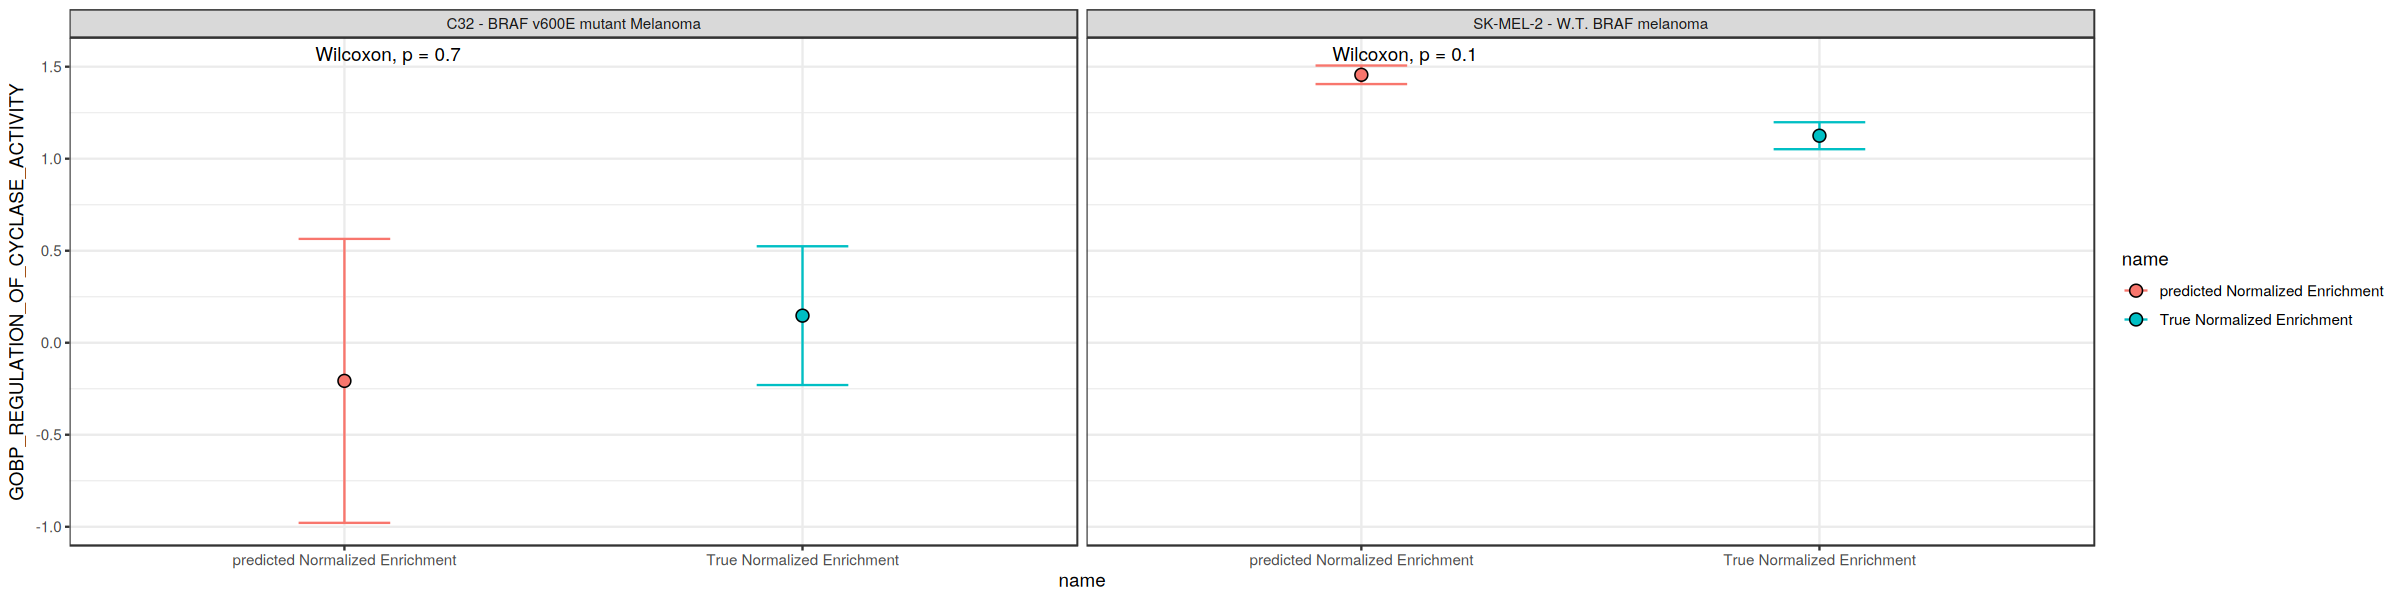

In [30]:
p <- ggplot(
  merged1 %>% filter(pathway %in% set),
  aes(x = name, y = value)
) +
  geom_errorbar(
    data = summary_df,
    aes(
      x = name,
      y = mean_value,
      ymin = mean_value - se,
      ymax = mean_value + se,
      color = name
    ),
    inherit.aes = FALSE,
    position = position_dodge(width = 0.5),
    width = 0.2
  ) +
  geom_point(
    data = summary_df,
    aes(x = name, y = mean_value, fill = name),
    inherit.aes = FALSE,
    position = position_dodge(width = 0.5),
    size = 3,
    shape = 21
  ) +
  stat_compare_means(aes(group = name)) +
  facet_wrap(~ cell_line, scales = "free_x") +  # ← test within each name
  theme_bw() +
  ylab("GOBP_REGULATION_OF_CYCLASE_ACTIVITY")
print(p)

In [36]:
ggsave('BRAF_enrichment_facets.pdf',p, width =20,height = 5)

In [34]:
sessionInfo()

R version 4.3.3 (2024-02-29)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 22.04.3 LTS

Matrix products: default
BLAS/LAPACK: /home/cachris/.conda/envs/gcloud/lib/libopenblasp-r0.3.27.so;  LAPACK version 3.12.0

locale:
 [1] LC_CTYPE=C.UTF-8       LC_NUMERIC=C           LC_TIME=C.UTF-8       
 [4] LC_COLLATE=C.UTF-8     LC_MONETARY=C.UTF-8    LC_MESSAGES=C.UTF-8   
 [7] LC_PAPER=C.UTF-8       LC_NAME=C              LC_ADDRESS=C          
[10] LC_TELEPHONE=C         LC_MEASUREMENT=C.UTF-8 LC_IDENTIFICATION=C   

time zone: America/Los_Angeles
tzcode source: system (glibc)

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] ggpubr_0.6.0        reticulate_1.41.0.1 fgsea_1.28.0       
 [4] lubridate_1.9.3     forcats_1.0.0       stringr_1.5.1      
 [7] purrr_1.0.4         tidyr_1.3.1         tibble_3.2.1       
[10] ggplot2_3.5.1       tidyverse_2.0.0     dplyr_1.1.4        
[13] readxl_1.4.3  